In [11]:
!pip install -U -q tensorflow tensorflow_datasets

In [12]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import  Speech Commands dataset

:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [37]:
data_dir = '/content/drive/MyDrive/SPEECHPROJ/my_voice_data'  # Change to your actual data path
model_path = '/content/drive/MyDrive/SPEECHPROJ/Saved_Models/my_model'

In [14]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['stop' 'visual' 'zero' 'wow' 'two' 'six' 'yes' 'tree' 'three' 'up'
 'marvin' 'nine' 'off' 'seven' 'one' 'left' 'sheila' 'on' 'right' 'no'
 'four' 'learn' 'forward' 'go' 'down' 'eight' 'follow' 'five' 'happy'
 'house' 'bird' 'cat' 'bed' 'dog' 'backward']


In [15]:
len(commands)

35

Preprocessing

In [16]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 700 files belonging to 35 classes.
Using 560 files for training.
Using 140 files for validation.

label names: ['backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'follow'
 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left' 'marvin' 'nine' 'no'
 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree'
 'two' 'up' 'visual' 'wow' 'yes' 'zero']


In [17]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [18]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [19]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [20]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Let's plot a few audio waveforms:

In [21]:
label_names[[1,1,3,0]]

array(['bed', 'bed', 'cat', 'backward'], dtype='<U8')

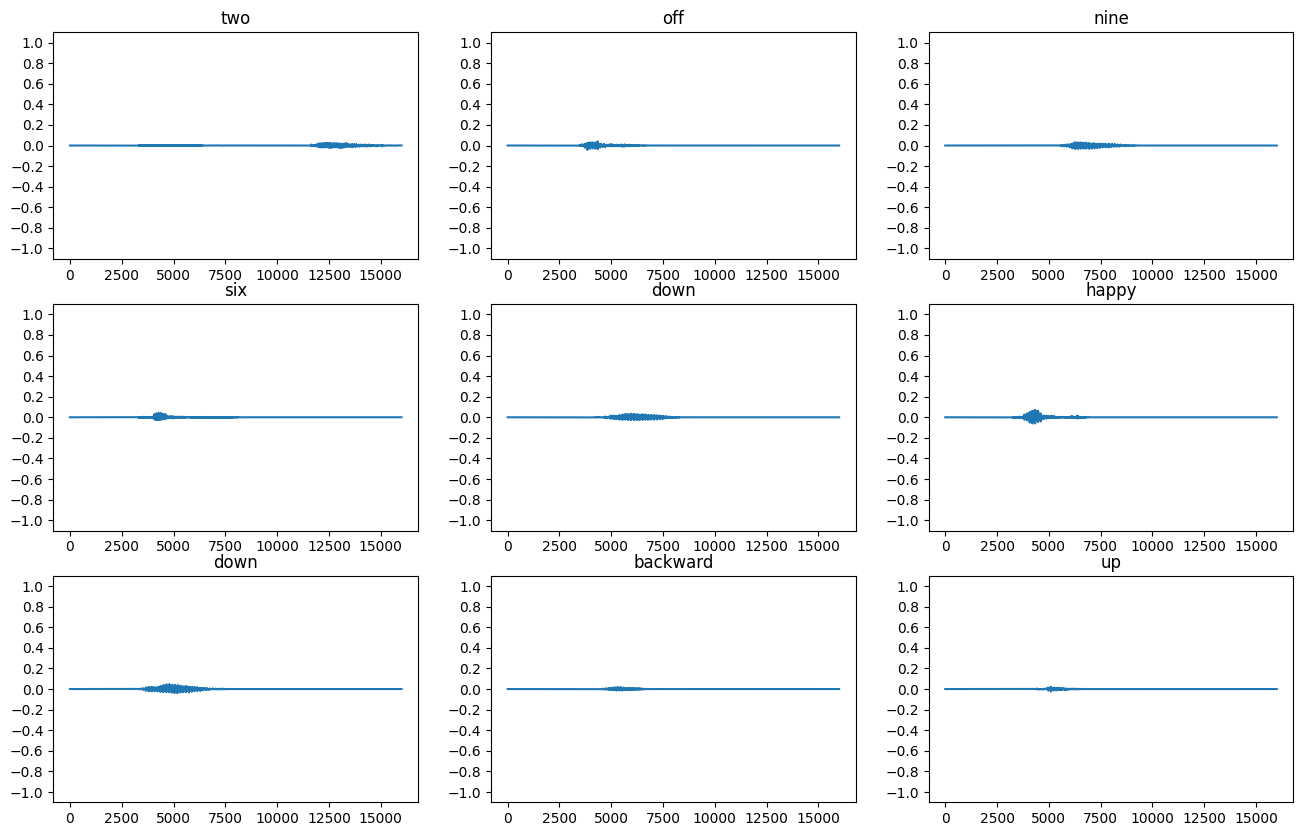

In [22]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms



In [23]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [24]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: two
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: off
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: nine
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


 function for displaying a spectrogram:

In [25]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

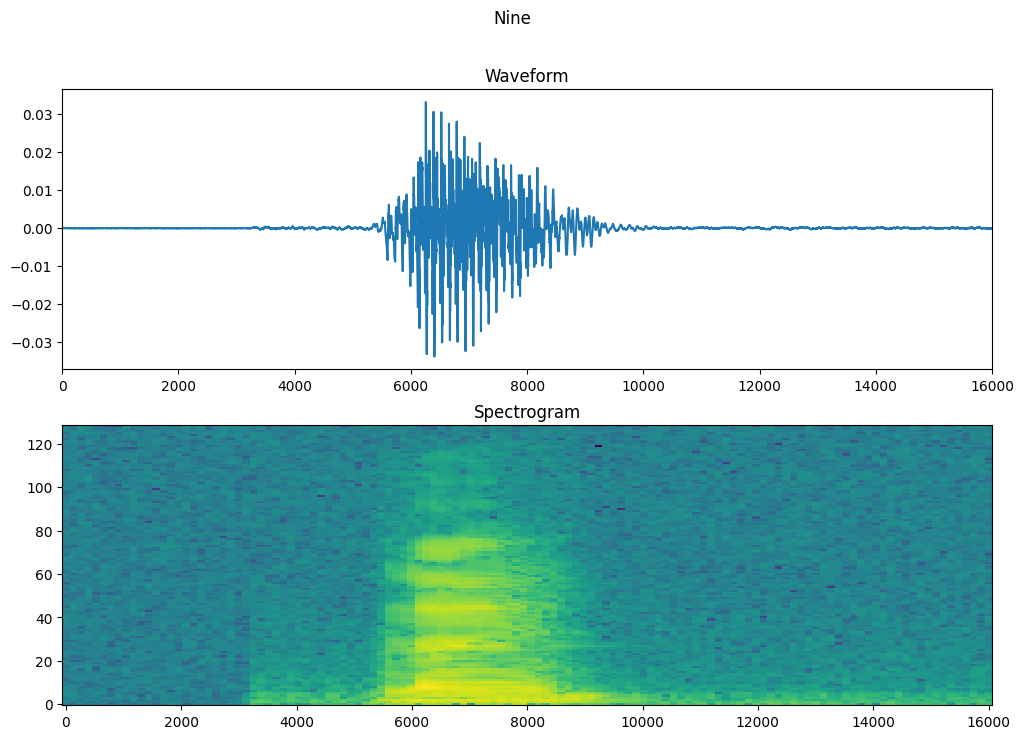

In [26]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

spectrogram datasets from the audio datasets:

In [27]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [28]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [29]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

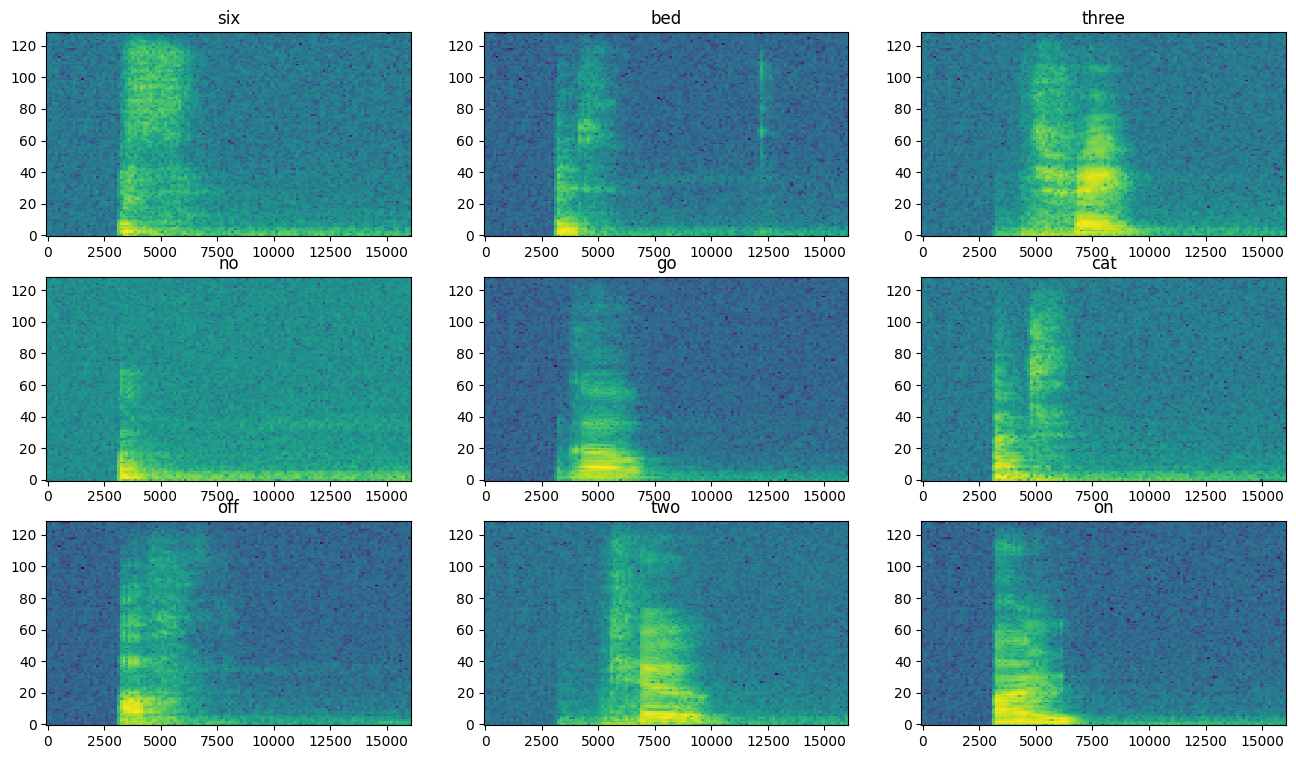

In [30]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Loading And Finetuning the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [31]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [34]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))


Input shape: (124, 129, 1)


In [42]:
model = tf.keras.models.load_model("/content/drive/MyDrive/SPEECHPROJ/keras_model.keras")



In [43]:
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=['accuracy'],
# )
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Set a lower learning rate for fine-tuning
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [48]:
EPOCHS = 5
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0382 - loss: 4.1501 - val_accuracy: 0.0625 - val_loss: 3.8351
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0498 - loss: 4.1695 - val_accuracy: 0.0625 - val_loss: 3.8241
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0223 - loss: 4.3125 - val_accuracy: 0.0625 - val_loss: 3.8131
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0318 - loss: 4.1431 - val_accuracy: 0.0625 - val_loss: 3.8028
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0413 - loss: 4.2226 - val_accuracy: 0.0625 - val_loss: 3.7924


Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

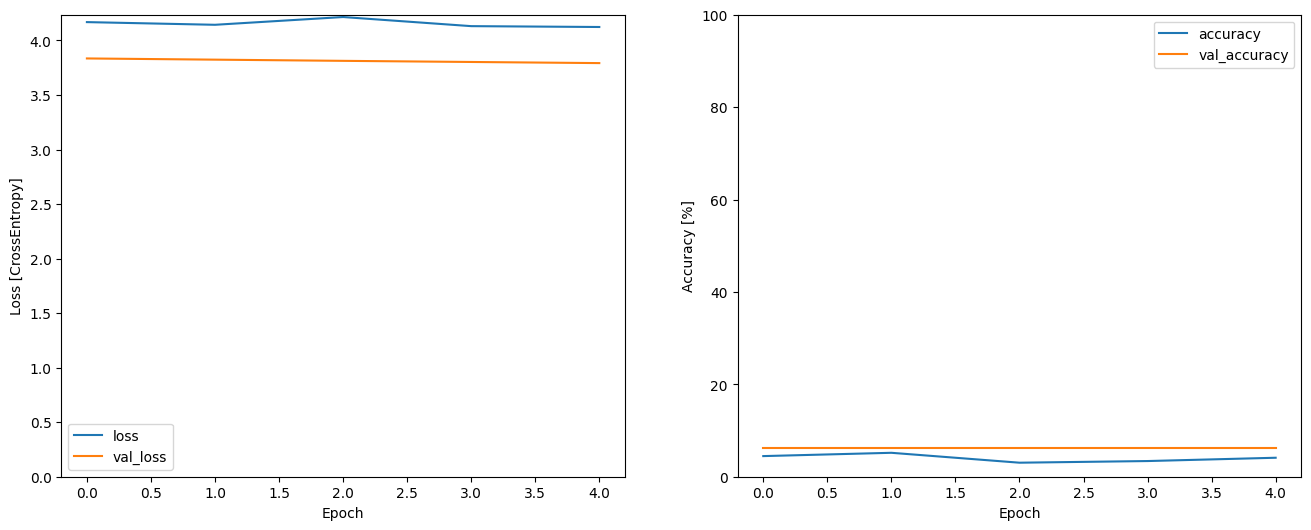

In [49]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [50]:
model.evaluate(test_spectrogram_ds, return_dict=True)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0455 - loss: 4.0158


{'accuracy': 0.05263157933950424, 'loss': 4.031558036804199}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [51]:
y_pred = model.predict(test_spectrogram_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 411ms/step


In [52]:
y_pred = tf.argmax(y_pred, axis=1)

In [53]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

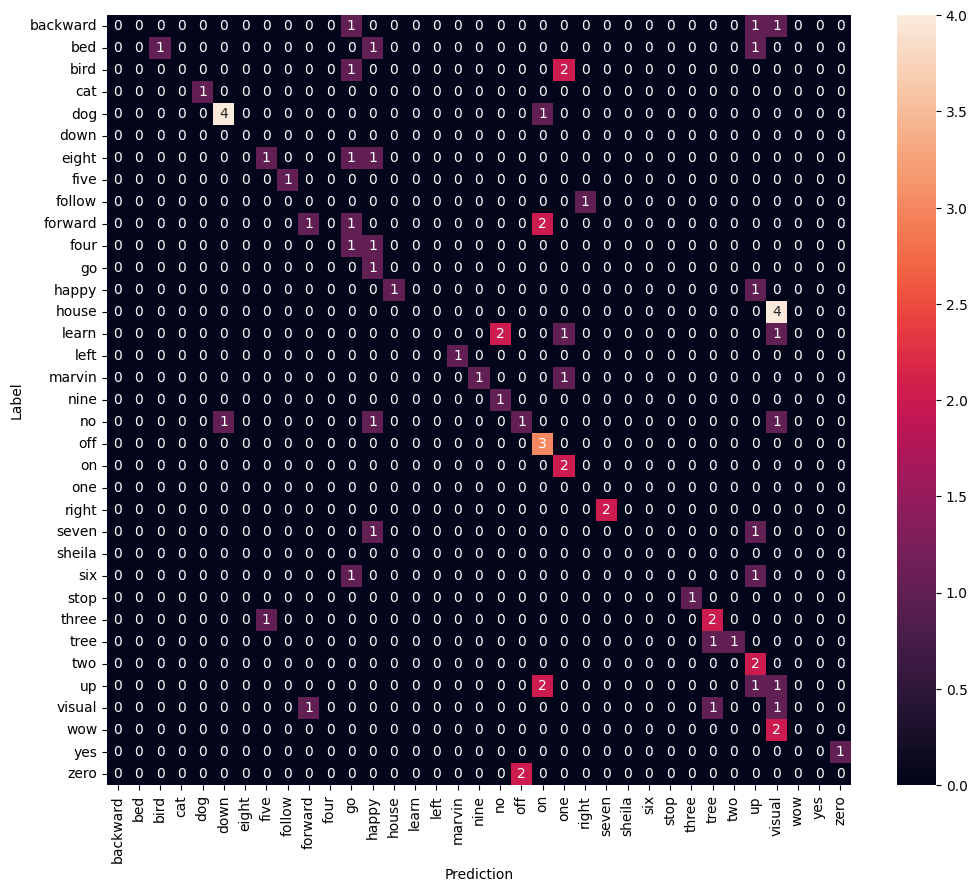

In [54]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

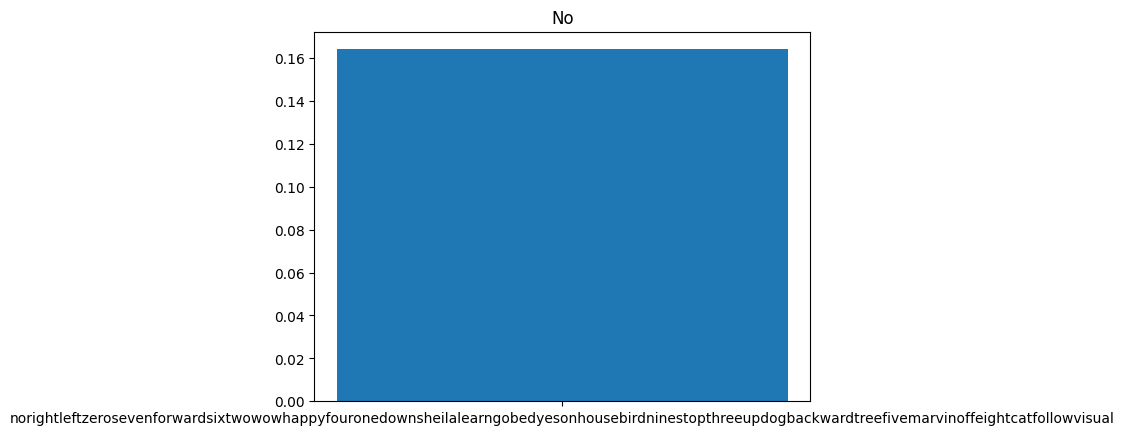

In [58]:
x = '/content/drive/MyDrive/SPEECHPROJ/my_voice_data/no/no_5.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no' 'right' 'left' 'zero' 'seven' 'forward' 'six'
 'two' 'wow' 'happy' 'four' 'one' 'down' 'sheila' 'learn' 'go' 'bed'
  'yes' 'on' 'house' 'bird' 'nine' 'stop' 'three'
 'up' 'dog' 'backward'  'tree'  'five' 'marvin'
 'off' 'eight' 'cat' 'follow' 'visual']



plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [60]:
model.save("/content/drive/MyDrive/SPEECHPROJ/Saved_Models/finetuned_model.keras")